---
# Imports

In [1]:
# Write your code here. Add as many boxes as you need.
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

---
# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of **atmospheric data** in Skopje. Your task involves employing bagging and boosting methods to forecast the **required measurements**. To accomplish this you will be using Pulse Eco Skopje measurements from **1 sensor**, which consists of the following values:

- Measurement Type (humidity, noise_dba, pm10, pm25, temperature)
- Value (Measured value for the given type)
- Stamp (A timestamp of the measurement)

**Note: You are required to perform this laboratory assignment on your local machine.**


# Read the data

You are required to load the given data from the `pulse_eco_one_sensor_data.csv` file. Load the data into a `pandas dataframe` and display the first 5 rows of the dataframe.

In [2]:
df = pd.read_csv("pulse_eco_one_sensor_data.csv")
df # Write your code here. Add as many boxes as you need.


,Type,Value,Stamp
0,humidity,87,2023-01-01T01:06:45+01:00
1,humidity,87,2023-01-01T01:22:18+01:00
2,humidity,87,2023-01-01T01:37:50+01:00
3,humidity,87,2023-01-01T01:53:21+01:00
4,humidity,87,2023-01-01T02:08:53+01:00
...,...,...,...
307202,temperature,2,2024-11-21T22:52:31+01:00
307203,temperature,2,2024-11-21T23:08:02+01:00
307204,temperature,2,2024-11-21T23:23:33+01:00
307205,temperature,2,2024-11-21T23:39:05+01:00


---
# Data Preprocessing

## Group the 'Stamp' column into 15 minute intervals

As the sensor produce data in infrequent intervals, we need to resample the data to 15 minute intervals. To do this you will need to:

- Convert the 'timestamp' column to a datetime object (use `pd.to_datetime` function ([Documentation](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)), with the `utc` argument set to `True`) 
- Floor each timestamp to the nearest 15 minutes (use the `.dt.floor` method ([Documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.floor.html)))


Example of `.dt.floor` for 1h:
- data['TimeStamp'] = data['TimeStamp'].dt.floor('1h') 

In [3]:
# Write your code here. Add as many boxes as you need.
df['Stamp'] = pd.to_datetime(df['Stamp'], utc=True)
df['Stamp'] = df['Stamp'].dt.floor('15min')
df

,Type,Value,Stamp
0,humidity,87,2023-01-01 00:00:00+00:00
1,humidity,87,2023-01-01 00:15:00+00:00
2,humidity,87,2023-01-01 00:30:00+00:00
3,humidity,87,2023-01-01 00:45:00+00:00
4,humidity,87,2023-01-01 01:00:00+00:00
...,...,...,...
307202,temperature,2,2024-11-21 21:45:00+00:00
307203,temperature,2,2024-11-21 22:00:00+00:00
307204,temperature,2,2024-11-21 22:15:00+00:00
307205,temperature,2,2024-11-21 22:30:00+00:00


Check if the operation was successful by displaying the first 5 rows of the data frame.

In [4]:
# Write your code here. Add as many boxes as you need.

## Sensor data to Pivot Table

To combine each measurement with the corresponding weather data, we will create a pivot table with the weather data and group the measurements by timestamp. Moreover, we will resample for each 15min, to add missing measurements.

**DO NOT MODIFY THE FOLLOWING CELLS, except for changing the df name.**

This operations will be given by the following code:

In [5]:
pivot = df.pivot_table(index='Stamp', columns='Type', values='Value', aggfunc='mean')
pivot = pivot.resample('15min').first()

In [6]:
pivot.head(3)

Type,humidity,noise_dba,pm10,pm25,temperature
Stamp,,,,,
2023-01-01 00:00:00+00:00,87.0,45.0,473.0,156.0,5.0
2023-01-01 00:15:00+00:00,87.0,44.0,333.0,120.0,5.0
2023-01-01 00:30:00+00:00,87.0,46.0,328.0,108.0,5.0


## Missing values

### Check for missing values 

Check if there are any missing values in the pivot data.

In [7]:
# Write your code here. Add as many boxes as you need.
pivot.isnull().sum()

Type
humidity       5010
noise_dba      3804
pm10           5317
pm25           5312
temperature    5010
dtype: int64

### Check for reason of missing values

Check if there is any reason for the missing data in the dataset.

<Axes: xlabel='Type', ylabel='Type'>

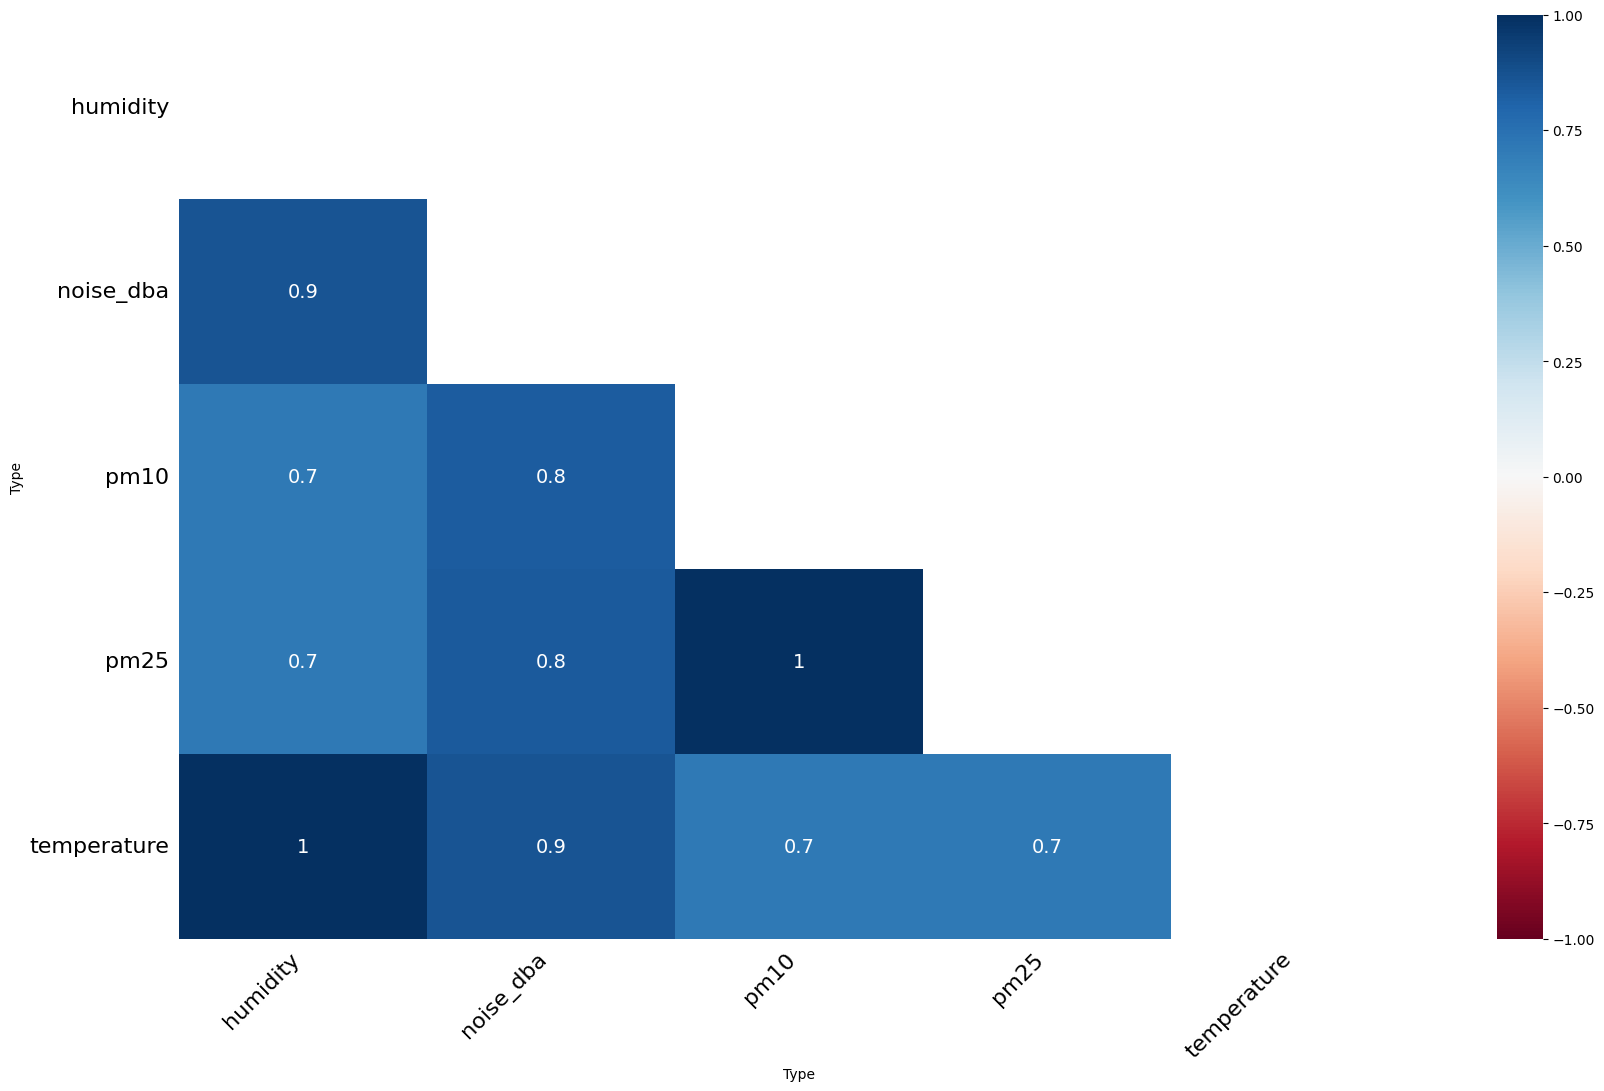

In [9]:
# Write your code here. Add as many boxes as you need.
msno.heatmap(pivot)

### Deal with missing values (Interpolation)

Use the `Interpolation` method to fill in the missing values in the dataset.

In [10]:
# Write your code here. Add as many boxes as you need.
pivot.interpolate(method='cubic', limit_direction='both', inplace=True) 

#### Check if there are any missing values (Sanity Check)

Recheck for missing values.

In [11]:
# Write your code here. Add as many boxes as you need.
pivot.isnull().sum()

Type
humidity       0
noise_dba      0
pm10           0
pm25           0
temperature    0
dtype: int64

---
# Feature Engineering

## Drop Noise DBA as it is not relevant.

In [12]:
# Write your code here. Add as many boxes as you need.
pivot.drop(columns=['noise_dba'], inplace=True)

Check that the drop was successful.

In [13]:
# Write your code here. Add as many boxes as you need.
pivot

Type,humidity,pm10,pm25,temperature
Stamp,,,,
2023-01-01 00:00:00+00:00,87.0,473.0,156.0,5.0
2023-01-01 00:15:00+00:00,87.0,333.0,120.0,5.0
2023-01-01 00:30:00+00:00,87.0,328.0,108.0,5.0
2023-01-01 00:45:00+00:00,87.0,415.0,125.0,5.0
2023-01-01 01:00:00+00:00,87.0,341.0,110.0,5.0
...,...,...,...,...
2024-11-21 21:45:00+00:00,74.0,108.0,47.0,2.0
2024-11-21 22:00:00+00:00,74.0,79.0,35.0,2.0
2024-11-21 22:15:00+00:00,74.0,81.0,33.0,2.0


## Create Lag Features (3 prev values) for each measurement

Apply a lag of 15min, 30min, and 45min (3x15min intervals) to each feature, creating a set of features representing the meteorological conditions from the previous 45 minutes. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [14]:
# Write your code here. Add as many boxes as you need.
COLUMNS = pivot.columns

for column in COLUMNS:
    for i in range(1, 4):
        pivot[f'{column}_shift_{i}'] = pivot[column].shift(i)

In [16]:
# Write your code here. Add as many boxes as you need.
pivot.dropna(inplace=True)

## Check Correlation between the extracted features and target

<Axes: xlabel='Type', ylabel='Type'>

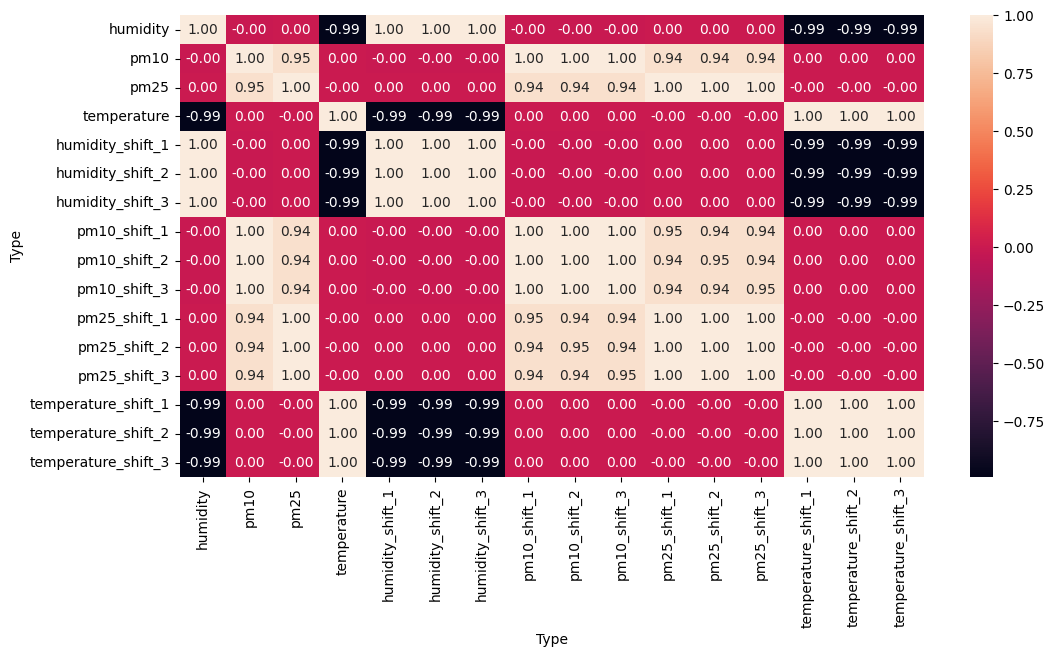

In [17]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(12, 6))
sns.heatmap(pivot.corr(), annot=True, fmt=".2f")

---
# Train and test models

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**RECOMMENDATION: Use only first 1 000 data points.**

**WARNING: DO NOT SHUFFLE THE DATASET.**

**Columns for prediction:**
- 'humidity'
- 'pm25'
- 'pm10' 
- 'temperature'

In [18]:
pivot.sort_index(inplace=True)

In [19]:
# Write your code here. Add as many boxes as you need.
X = pivot.drop(columns=COLUMNS).head(1000)
y = pivot[COLUMNS].head(1000)

In [20]:
# Write your code here. Add as many boxes as you need.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Ensemble Learning Methods

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [21]:
# Write your code here. Add as many boxes as you need.
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Use the trained model to make predictions for the test set.

In [22]:
# Write your code here. Add as many boxes as you need.
y_pred = xgb.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

Output independent metrics for each column you predict. 

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the number of estimators (`n_estimators`) for the XGBoost model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `n_estimators` and evaluating the model's performance using cross-validation. Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [ ]:
# Write your code here. Add as many boxes as you need.

## Fine-tuning the XGBoost Hyperparameter
Experiment with various values for `n_estimators` and evaluate the model's performance using cross-validation.

In [ ]:
# Write your code here. Add as many boxes as you need.

## Final Assessment of the Model Performance
Upon determining the most suitable `n_estimators` value, evaluate the model's performance on a test set for final assessment.

In [ ]:
# Write your code here. Add as many boxes as you need.

---